This notebook reproduces the functional sensitivity results in the paper

"Evaluating Sensitivity to the Stick Breaking Prior in Bayesian Nonparametrics"
https://arxiv.org/abs/1810.06587


It loads the model fits from './iris_fits/', so make sure to run the notebook `fit_base_model.ipynb` first. 

In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
sys.path.insert(0, '../../libraries/')
import gmm_clustering_lib as gmm_lib
import modeling_lib 
import utils_lib
import cluster_quantities_lib as cluster_lib
import optimization_lib
import functional_sensitivity_lib as fun_sens_lib 


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

from tqdm import tqdm

/home/runjing_liu/Documents/BNP/autograd/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

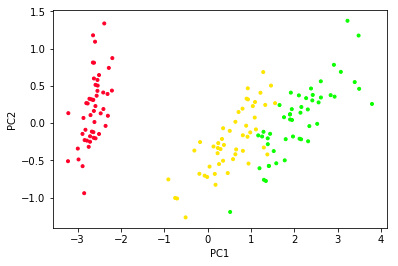

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load results from previous fit.

In [4]:
def assert_optimizer(features, vb_opt_dict, vb_params_paragami, prior_params_dict, gh_loc, gh_weights): 
    # this function checks that vb_opt_dict are at a kl optimum for the given 
    # prior parameters
    
    get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
    get_vb_params_loss.cache_args(features, None, prior_params_dict,
                                    gh_loc, gh_weights)
    get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
                                            patterns=vb_params_paragami,
                                            free=True)
    grad_get_loss = autograd.grad(get_loss)
    linf_grad = np.max(np.abs(grad_get_loss(vb_params_paragami.flatten(vb_opt_dict, free = True))))
    
    assert  linf_grad < 1e-5, 'error: {}'.format(linf_grad)


In [5]:
init_alpha = 8.0

# load optimal vb parameters at init_alpha
vb_opt_dict, vb_params_paragami, data =\
    paragami.load_folded('./iris_fits/iris_fits_alpha{}.npz'.format(init_alpha))

# free optimal vb_parameters
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# load prior parameters
prior_params_dict, prior_params_paragami = \
    gmm_lib.get_default_prior_params(dim = vb_opt_dict['centroids'].shape[0])
prior_params_dict['alpha'] = data['alpha']


# other parameters
gh_deg = int(data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

# optimal e_z
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

# assert we are at an optimum 
assert_optimizer(features, vb_opt_dict, vb_params_paragami, prior_params_dict, gh_loc, gh_weights)

### Plot results

In [6]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


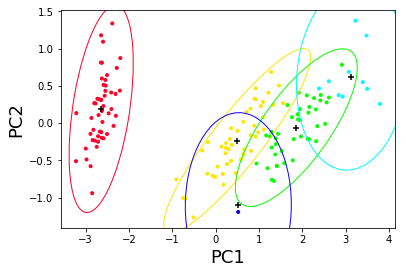

In [7]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Define a perturbation in the logit v space.

In [8]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.

phi_center = 2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
# def log_phi(logit_v):
#     return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


0.6931471805599453


In [9]:
# def phi(logit_v):
#     return 1 - np.exp(-sp.special.expit(logit_v))


# def log_phi(logit_v):
#      return(np.log(phi(logit_v)))

This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [10]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 10 * log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [11]:
quad_maxiter = 200

In [12]:
prior_perturbation = fun_sens_lib.PriorPerturbation(vb_params_dict = vb_opt_dict, 
                                                    alpha0 = prior_params_dict['alpha'],
                                                    gh_loc = gh_loc, 
                                                    gh_weights = gh_weights, 
                                                    log_phi = rescaled_log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-2.079441541679836 1.936236507197625 -2.0821248162554524 1.9385325300641851


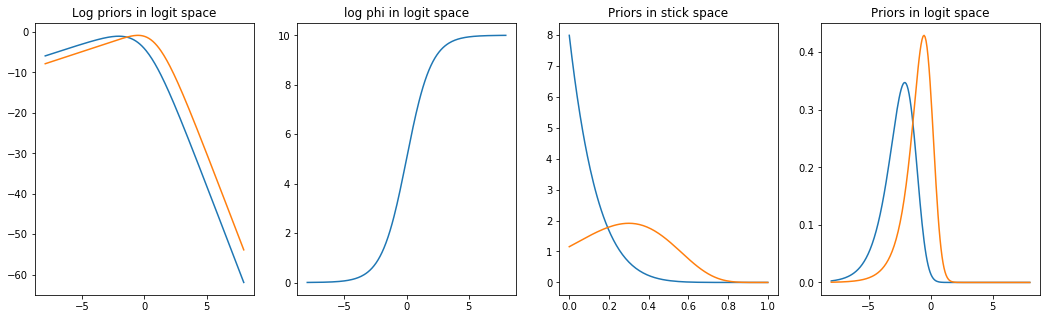

In [13]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


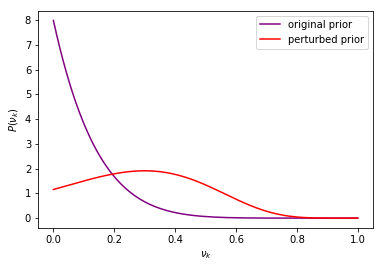

In [14]:
prior_perturbation.set_epsilon(1.0)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)), color = 'purple')
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)), color = 'red')
# plt.plot(v_grid, sp.stats.beta.pdf(v_grid, 1, 13), 'k--')

plt.ylabel('$P(\\nu_k)$')
plt.xlabel('$\\nu_k$')
plt.legend(('original prior', 'perturbed prior'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/perturbed_prior1_init3_5.png')

# Increase number of Gauss-hermite points.

In [15]:
# First fit with no perturbation but the increased number of gh points.

gh_loc, gh_weights = hermgauss(20)

# get loss as a function of vb parameters
get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
get_vb_params_loss.cache_args(features, None, prior_params_dict,
                                gh_loc, gh_weights)

# Get loss as a function vb_free_params
get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
                                        patterns=vb_params_paragami,
                                        free=True)

init_vb_free_params = deepcopy(vb_opt)
vb_opt, _ = optimization_lib.precondition_and_optimize(get_loss, init_vb_free_params,
                    maxiter = 50, gtol=1e-8)

print('Done. ')

computing preconditioner 
running newton steps
Optimization terminated successfully.
         Current function value: -337.207548
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. 


In [16]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

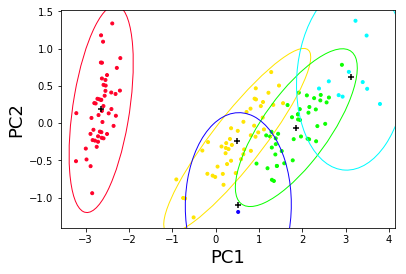

In [17]:
# plot results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Define prior perturbation

In [18]:
epsilon_param_dict = {'epsilon': np.array([1.0])}

epsilon_param_paragami = paragami.PatternDict() 
epsilon_param_paragami['epsilon'] = \
        paragami.NumericArrayPattern(shape=(1, ))

In [19]:
def get_e_log_perturbation(log_phi, vb_params_dict, epsilon_param_dict, 
                           gh_loc, gh_weights, sum_vector=True):
    perturbation_fun = \
        lambda logit_v: log_phi(logit_v) * epsilon_param_dict['epsilon']

    e_perturbation_vec = modeling_lib.get_e_func_logit_stick_vec(
        vb_params_dict, gh_loc, gh_weights, perturbation_fun)

    if sum_vector:
        return -1 * np.sum(e_perturbation_vec)
    else:
        return -1 * e_perturbation_vec


In [20]:
def get_perturbed_kl(y, vb_params_dict, epsilon_param_dict, log_phi, 
                     prior_params_dict, gh_loc, gh_weights, prior_perturbation): 
    
    e_log_pert = get_e_log_perturbation(log_phi, vb_params_dict, epsilon_param_dict, 
                           gh_loc, gh_weights, sum_vector=True)

    return gmm_lib.get_kl(y, vb_params_dict, prior_params_dict, gh_loc, gh_weights) + e_log_pert

In [38]:
# we will use this for the sensitivity class
get_epsilon_vb_loss = paragami.Functor(
    original_fun=get_perturbed_kl, argnums=[1, 2])

get_epsilon_vb_loss.cache_args(features, None, None, rescaled_log_phi, 
                     prior_params_dict, gh_loc, gh_weights, prior_perturbation)

In [39]:
# the only part of the kl that depends on epsilon
hyper_par_objective_fun = \
    paragami.Functor(get_e_log_perturbation, argnums = [1, 2])
    
hyper_par_objective_fun.cache_args(rescaled_log_phi, None, None, 
                           gh_loc, gh_weights)

In [40]:
epsilon_sens = \
    paragami.HyperparameterSensitivityLinearApproximation(
        objective_fun=           get_epsilon_vb_loss,
        opt_par_pattern=         vb_params_paragami,
        hyper_par_pattern=       epsilon_param_paragami,
        opt_par_folded_value=    vb_params_paragami.fold(vb_opt, free = True),
        hyper_par_folded_value=  epsilon_param_paragami.fold(0.0, free = False),
        opt_par_is_free=         True,
        hyper_par_is_free=       False,
        hyper_par_objective_fun = hyper_par_objective_fun,
        grad_tol=                1e-5)


In [42]:
get_e_log_perturbation(rescaled_log_phi, vb_opt_dict, epsilon_param_dict, 
                           gh_loc, gh_weights, sum_vector=True)

-46.44483903530594

## Fit with perturbation

In [61]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

vb_pert_pred = \
    epsilon_sens.predict_opt_par_from_hyper_par(epsilon_param_dict, fold_output = False)

print('Predicted differences: ', np.linalg.norm(vb_pert_opt_pred - vb_opt))

Epsilon:  1.0
Predicted differences:  6.189662015685443


In [63]:
vb_pert_pred_dict = vb_params_paragami.fold(vb_pert_pred, free = True)
e_z_pert_pred = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_pred_dict, gh_loc, gh_weights)

In [50]:
# we will use this for optimization
get_perturbed_vb_loss = paragami.Functor(
    original_fun=get_perturbed_kl, argnums=[1])

get_perturbed_vb_loss.cache_args(features, None, epsilon_param_dict, rescaled_log_phi, 
                     prior_params_dict, gh_loc, gh_weights, prior_perturbation)

get_perturbed_vb_loss_flattened = \
    paragami.FlattenedFunction(original_fun=get_perturbed_vb_loss,
                                patterns=vb_params_paragami,
                                free=True)


In [51]:
vb_pert_opt = optimization_lib.optimize_full(get_perturbed_vb_loss_flattened, deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: -404.768417
         Iterations: 113
         Function evaluations: 136
         Gradient evaluations: 135

 running preconditioned newton; iter =  0
computing preconditioner 
running newton steps
         Current function value: -404.768417
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 3
         Hessian evaluations: 0
Iter 0: x_diff = 5.508261644908327e-06, f_diff = 7.958078640513122e-13, grad_l1 = 3.4438840124815486e-06
done. 


In [57]:
vb_pert_opt_dict = vb_params_paragami.fold(vb_pert_opt, free = True)
e_z_pert_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_opt_dict, gh_loc, gh_weights)

Epsilon: 1.0


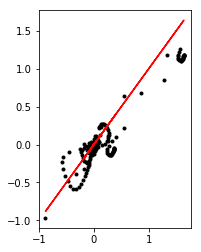

In [64]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vb_pert_opt - vb_opt, vb_pert_pred - vb_opt, 'k.')
plt.plot(vb_pert_opt - vb_opt, vb_pert_opt - vb_opt, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [67]:
print('original expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_opt_dict['stick_propn_mean'], 
                                                        vb_opt_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('perturbed expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_opt_dict['stick_propn_mean'], 
                                                        vb_pert_opt_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('predicted expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_pred_dict['stick_propn_mean'], 
                                                        vb_pert_pred_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))


      

original expected number of clusters:  11.004051506192306
perturbed expected number of clusters:  8.428314352301086
predicted expected number of clusters:  8.216724412345858


# Predict for a range of perturbations

In [68]:
#epsilon_vec = np.append(np.linspace(0, 0.1, 6), np.linspace(0.2, 1.0, 6))
epsilon_vec = np.linspace(0, 1, 11) ** 2 # Square to get more points close to 0
# epsilon_vec = -np.linspace(0, 10, 11)
print(epsilon_vec)

[0.   0.01 0.04 0.09 0.16 0.25 0.36 0.49 0.64 0.81 1.  ]


In [82]:
def refit_with_epsilon(epsilon_param_dict, vb_opt):
        
    # set up new objective, with the prior changed
    get_perturbed_vb_loss = paragami.Functor(
        original_fun=get_perturbed_kl, argnums=[1])
    
    get_perturbed_vb_loss.cache_args(features, None, epsilon_param_dict, rescaled_log_phi, 
                         prior_params_dict, gh_loc, gh_weights, prior_perturbation)

    get_perturbed_vb_loss_flattened = \
        paragami.FlattenedFunction(original_fun=get_perturbed_vb_loss,
                                    patterns=vb_params_paragami,
                                    free=True)
    
    # optimize
    vb_opt_pert = optimization_lib.optimize_full(get_perturbed_vb_loss_flattened, deepcopy(vb_opt),
                    bfgs_max_iter = 0, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

In [84]:
vb_pert_opt_array = []
vb_pert_pred_array = []


for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    epsilon_param_dict = {'epsilon': np.array([epsilon])}
    
    # get linear predictions
    vb_pert_pred = \
        epsilon_sens.predict_opt_par_from_hyper_par(epsilon_param_dict, fold_output = False)

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    
    # Then fit with the perturbation.
    vb_pert_opt = refit_with_epsilon(epsilon_param_dict, vb_opt)
    
    print('Done. ')

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(vb_pert_opt - vb_opt))
    
    # save results: 
    vb_pert_opt_array.append(vb_pert_opt)
    vb_pert_pred_array.append(vb_pert_pred)
    




Epsilon:  0.0
Predicted differences:  1.9263381482332143e-15
running bfgs ... 
         Current function value: -337.207548
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

 running preconditioned newton; iter =  0
computing preconditioner 
running newton steps
Optimization terminated successfully.
         Current function value: -337.207548
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 0: x_diff = 2.155554936476324e-12, f_diff = 1.5916157281026244e-12, grad_l1 = 1.5524431317524113e-08
done. 
Done. 
Predicted differences:  1.9263381482332143e-15
Actual differences: (This is nonzero if phi did anything): 1.8987962169481685e-13


Epsilon:  0.010000000000000002
Predicted differences:  0.061896620156854244
running bfgs ... 
         Current function value: -337.671997
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

 running pr

/home/runjing_liu/Documents/BNP/autograd/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


         Current function value: -404.768417
         Iterations: 49
         Function evaluations: 51
         Gradient evaluations: 43
         Hessian evaluations: 0
Iter 0: x_diff = 65.39519640601937, f_diff = 21.11602985809344, grad_l1 = 1.7703479486841516e-06

 running preconditioned newton; iter =  1
computing preconditioner 
running newton steps
         Current function value: -404.768417
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 1: x_diff = 1.95484423775922e-12, f_diff = 0.0, grad_l1 = 1.7703491154861541e-06
done. 
Done. 
Predicted differences:  6.189662015685443
Actual differences: (This is nonzero if phi did anything): 8.237861903236487


In [85]:
# np.save('best_param_phi_array', best_param_phi_array)

In [38]:
# output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)
# output_0 = \
#     gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_0, model)


In [39]:
# for i in range(len(epsilon_vec)): 
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_pred_array[i] - best_param_0, 'k.')
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_array[i] - best_param_0, 'r')
#     plt.xlabel('true diff global free params')
#     plt.ylabel('pred diff global free params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))

#     plt.subplot(1, 2, 2)
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_pred_array[i] - output_0, 'k.')
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_array[i] - output_0, 'r')
#     plt.xlabel('true diff moment params')
#     plt.ylabel('pred diff moment params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
#     plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [89]:
from tqdm import tqdm

In [90]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_pred_array[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_opt_array[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


100%|██████████| 11/11 [01:30<00:00,  8.22s/it]


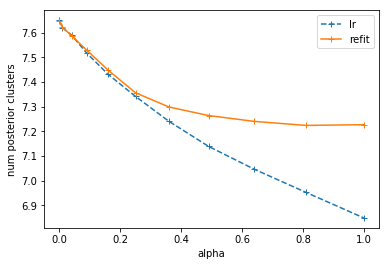

In [92]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

# plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


In [95]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_pred_array[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_opt_array[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


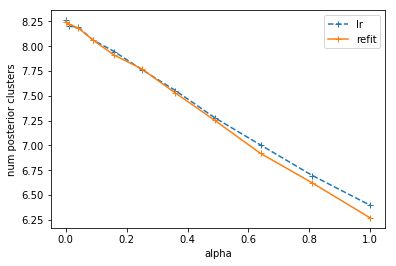

In [98]:
plt.plot(epsilon_vec, lr_e_num_pred_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))